In [83]:
from sklearn.metrics import ndcg_score, average_precision_score
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import numpy as np
import pandas as pd
from utils import load_df_with_keys, load_vecs
from sklearn.cluster import HDBSCAN, DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from flask_functions_copy import *

In [84]:
# load in data
df, np_embs, keyword_lines= build_data_new()
queries = set(df['for_query_en'])
# default vals
eps=0.3
min_samples = 5
query = 'atomic heart'
country_bias=''

0 <class 'str'>


In [7]:

results, wdf, cluster_df = query_ranker(query, df,keyword_lines, np_embs,eps=eps, min_samples=min_samples, bias=country_bias)


testing on query:atomic heart
{'eps': 0.3, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


In [10]:
pd.DataFrame(results)

,result_id,country,for_query,for_query_en,title_en,snippet_en,doc_en,rank,links,annotated_discordance,keys,cluster_id,cluster_x,cluster_y,discordance,cluster_size,abs_discordance,cluster_prop
9,11,us,atomic heart,atomic heart,Atomic Heart,Atomic Heart is a colorful title with a grippi...,Movie Reviews TV Reviews Game Reviews and Musi...,7.0,https://www.metacritic.com/game/atomic-heart/,2.0,atomic heart,0,14.626406,-0.208468,0.958333,9,0.333333,0.333333
3,4,ru,atomic heart,atomic heart,Atomic Heart,Atomic Heart (from English - “Atomic Heart”) -...,Wikipedia is a free encyclopedias of the Wikip...,5.0,https://ru.wikipedia.org/wiki/Atomic_Heart,2.0,atomic heart,0,14.626406,-0.208468,0.944444,9,0.333333,0.333333
6,7,ru,atomic heart,atomic heart,Atomic Heart,Welcome to the official channel of Mundfish st...,YouTubeAboutPressCopyrightContact usCreatorsAd...,8.0,https://www.youtube.com/channel/UCjAij4NWCod80...,1.0,mugfish,-1,14.176532,0.009029,0.944444,42,0.571429,0.571429
5,6,ru,atomic heart,atomic heart,Atomic Heart,Welcome to the official channel of Mundfish st...,YouTubeAboutPressCopyrightContact usCreatorsAd...,7.0,https://www.youtube.com/@Mundfish,1.0,atomic heart,0,14.626406,-0.208468,0.916667,9,0.333333,0.333333
0,1,ru,atomic heart,atomic heart,Atomic Heart on Steam,,Welcome to SteamLoginStoreHomeDiscovery QueueW...,2.0,https://store.steampowered.com/app/668580/Atom...,1.0,atomic heart,0,14.626406,-0.208468,0.885185,9,0.333333,0.333333
1,2,ru,atomic heart,atomic heart,Atomic Heart | Exclusively on VK Play,,"Atomic Heart | Exclusively at VK Playige, it h...",3.0,https://atomicheart.vkplay.ru/,1.0,atomic heart,0,14.626406,-0.208468,0.861111,9,0.333333,0.333333
4,5,ru,atomic heart,atomic heart,Atomic Heart,,VK.com | VKYour browser is out of dateThis may...,6.0,https://vk.com/atomicheart_game,3.0,atomic heart,0,14.626406,-0.208468,0.741667,9,0.333333,0.333333
2,3,ru,atomic heart,atomic heart,Atomic Heart,,Wikipedia the free encyclopediaJump to content...,4.0,https://en.wikipedia.org/wiki/Atomic_Heart,2.0,atomic heart,0,14.626406,-0.208468,0.741667,9,0.333333,0.333333
7,9,us,atomic heart,atomic heart,Atomic Heart,,Home - Focus EntertainmentBanishers: Ghosts of...,5.0,https://www.focus-entmt.com/en/games/atomic-heart,1.0,atomic heart,0,14.626406,-0.208468,0.741667,9,0.333333,0.333333
8,10,us,atomic heart,atomic heart,Atomic Heart,,Xbox Official Site: Consoles Games and Communi...,6.0,https://www.xbox.com/en-US/games/atomic-heart,1.0,atomic heart,0,14.626406,-0.208468,0.741667,9,0.333333,0.333333


In [101]:
base_rec = []
stat_rec = []
test_df = df
queries_ann = set(test_df['for_query_en'])
disc = pd.DataFrame()
for q in queries_ann:
    for eps in [0.1, 0.5,0.9]:
        for min_samples in [2,5,8]:
            for country_bias in [False,'us','ru']:
                _, results,_ = query_ranker(q, test_df,keyword_lines, np_embs,eps=eps, min_samples=min_samples, bias=country_bias)
                disc = pd.concat([disc, results])
                results = list(zip(results['result_id'],results['discordance']*5))
                # print(results)

                truth = test_df[test_df['for_query_en']==q].reset_index(drop=True)#['annotated_discordance'].sort_values(ascending=False).to_numpy() # when 3 or above
                truth_scores = truth.set_index('result_id')['annotated_discordance'].to_dict()
                # organize by result id
                mtscores = []
                mrscores = []
                nrscores = []
                for rid,score in results:
                    mrscores.append([score])#(1 if int(score) > 2 else 0)
                    mtscores.append(truth_scores[rid])#(1 if truth_scores[rid] > 2 else 0)

                mp = average_precision_score(np.array(mtscores), np.array(mrscores))
                resscores = np.array([x[1] for x in results])
                ng = ndcg_score(np.array(mtscores)[:,None].T, resscores[:,None].T,k=10)
                base_rec.append([q, 'map',mp,eps,min_samples,country_bias])
                base_rec.append([q, 'ndcg',ng,eps,min_samples,country_bias])


                stat_rec.append([q,stats.ks_2samp(mtscores, [b[1] for b in results])[1],eps,min_samples,country_bias])
statdf=  pd.DataFrame().from_records(stat_rec, columns=['query','value','eps','min_samples','bias'])
basedf = pd.DataFrame().from_records(base_rec, columns=['query','score','value','eps','min_samples','bias'])

testing on query:news
{'eps': 0.1, 'min_samples': 2}
testing on query:news
{'eps': 0.1, 'min_samples': 2}
testing on query:news
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:news
{'eps': 0.1, 'min_samples': 5}
testing on query:news
{'eps': 0.1, 'min_samples': 5}
testing on query:news
{'eps': 0.1, 'min_samples': 5}
testing on query:news
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:news
{'eps': 0.1, 'min_samples': 8}
testing on query:news
{'eps': 0.1, 'min_samples': 8}
testing on query:news
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:news
{'eps': 0.5, 'min_samples': 2}
testing on query:news
{'eps': 0.5, 'min_samples': 2}
testing on query:news
{'eps': 0.5, 'min_samples': 5}
testing on query:news
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:news
{'eps': 0.5, 'min_samples': 5}
testing on query:news
{'eps': 0.5, 'min_samples': 8}
testing on query:news
{'eps': 0.5, 'min_samples': 8}
testing on query:news
{'eps': 0.5, 'min_samples': 8}
testing on query:news
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:news
{'eps': 0.9, 'min_samples': 2}
testing on query:news
{'eps': 0.9, 'min_samples': 2}
testing on query:news
{'eps': 0.9, 'min_samples': 5}
testing on query:news
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:news
{'eps': 0.9, 'min_samples': 5}
testing on query:news
{'eps': 0.9, 'min_samples': 8}
testing on query:news
{'eps': 0.9, 'min_samples': 8}
testing on query:news
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 5}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 5}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 5}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 8}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 8}
testing on query:Happy birthday
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 5}
testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 5}
testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 8}
testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 8}
testing on query:Happy birthday
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 2}
testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 5}
testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 5}
testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 8}
testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 8}
testing on query:Happy birthday
{'eps': 0.9, 'min_samples': 8}
testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 2}
testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 2}
testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 8}
testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 8}
testing on query:Cheburashka
{'eps': 0.1, 'min_samples': 8}
testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 2}
testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 2}
testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 8}
testing on query:Cheburashka
{'eps': 0.5, 'min_samples': 8}
testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 2}
testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 2}
testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 5}
testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 8}
testing on query:Cheburashka


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

{'eps': 0.9, 'min_samples': 8}
testing on query:Cheburashka
{'eps': 0.9, 'min_samples': 8}
testing on query:classmates
{'eps': 0.1, 'min_samples': 2}
testing on query:classmates
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:classmates
{'eps': 0.1, 'min_samples': 2}
testing on query:classmates
{'eps': 0.1, 'min_samples': 5}
testing on query:classmates
{'eps': 0.1, 'min_samples': 5}
testing on query:classmates
{'eps': 0.1, 'min_samples': 5}
testing on query:classmates
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:classmates
{'eps': 0.1, 'min_samples': 8}
testing on query:classmates
{'eps': 0.1, 'min_samples': 8}
testing on query:classmates
{'eps': 0.5, 'min_samples': 2}
testing on query:classmates
{'eps': 0.5, 'min_samples': 2}
testing on query:classmates
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:classmates
{'eps': 0.5, 'min_samples': 5}
testing on query:classmates
{'eps': 0.5, 'min_samples': 5}
testing on query:classmates
{'eps': 0.5, 'min_samples': 5}
testing on query:classmates
{'eps': 0.5, 'min_samples': 8}
testing on query:classmates
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:classmates
{'eps': 0.5, 'min_samples': 8}
testing on query:classmates
{'eps': 0.9, 'min_samples': 2}
testing on query:classmates
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:classmates
{'eps': 0.9, 'min_samples': 2}
testing on query:classmates
{'eps': 0.9, 'min_samples': 5}
testing on query:classmates
{'eps': 0.9, 'min_samples': 5}
testing on query:classmates
{'eps': 0.9, 'min_samples': 5}
testing on query:classmates
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:classmates
{'eps': 0.9, 'min_samples': 8}
testing on query:classmates
{'eps': 0.9, 'min_samples': 8}
testing on query:Gdz
{'eps': 0.1, 'min_samples': 2}
testing on query:Gdz
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gdz
{'eps': 0.1, 'min_samples': 2}
testing on query:Gdz
{'eps': 0.1, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.1, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.1, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gdz
{'eps': 0.1, 'min_samples': 8}
testing on query:Gdz
{'eps': 0.1, 'min_samples': 8}
testing on query:Gdz
{'eps': 0.5, 'min_samples': 2}
testing on query:Gdz
{'eps': 0.5, 'min_samples': 2}
testing on query:Gdz
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gdz
{'eps': 0.5, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.5, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.5, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.5, 'min_samples': 8}
testing on query:Gdz
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gdz
{'eps': 0.5, 'min_samples': 8}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 2}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 2}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 2}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gdz
{'eps': 0.9, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 5}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 8}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 8}
testing on query:Gdz
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 2}
testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 2}
testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 2}
testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 5}
testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 5}
testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 8}
testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 8}
testing on query:Gypsophyla
{'eps': 0.1, 'min_samples': 8}
testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 2}
testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 2}
testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 5}
testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 5}
testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 8}
testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 8}
testing on query:Gypsophyla
{'eps': 0.5, 'min_samples': 8}
testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 2}
testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 2}
testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 5}
testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 5}
testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 5}
testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 8}
testing on query:Gypsophyla
{'eps': 0.9, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 2}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 2}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 2}
testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 2}
testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 2}
testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.5, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 2}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 2}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 5}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 8}
testing on query:Inna Churikova
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translator
{'eps': 0.1, 'min_samples': 2}
testing on query:translator
{'eps': 0.1, 'min_samples': 2}
testing on query:translator
{'eps': 0.1, 'min_samples': 2}
testing on query:translator
{'eps': 0.1, 'min_samples': 5}
testing on query:translator
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translator
{'eps': 0.1, 'min_samples': 5}
testing on query:translator
{'eps': 0.1, 'min_samples': 8}
testing on query:translator
{'eps': 0.1, 'min_samples': 8}
testing on query:translator
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translator
{'eps': 0.5, 'min_samples': 2}
testing on query:translator
{'eps': 0.5, 'min_samples': 2}
testing on query:translator
{'eps': 0.5, 'min_samples': 2}
testing on query:translator
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translator
{'eps': 0.5, 'min_samples': 5}
testing on query:translator
{'eps': 0.5, 'min_samples': 5}
testing on query:translator
{'eps': 0.5, 'min_samples': 8}
testing on query:translator
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translator
{'eps': 0.5, 'min_samples': 8}
testing on query:translator
{'eps': 0.9, 'min_samples': 2}
testing on query:translator
{'eps': 0.9, 'min_samples': 2}
testing on query:translator
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translator
{'eps': 0.9, 'min_samples': 5}
testing on query:translator
{'eps': 0.9, 'min_samples': 5}
testing on query:translator
{'eps': 0.9, 'min_samples': 5}
testing on query:translator
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translator
{'eps': 0.9, 'min_samples': 8}
testing on query:translator
{'eps': 0.9, 'min_samples': 8}
testing on query:atomic heart
{'eps': 0.1, 'min_samples': 2}
testing on query:atomic heart
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:atomic heart
{'eps': 0.1, 'min_samples': 2}
testing on query:atomic heart
{'eps': 0.1, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.1, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.1, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:atomic heart
{'eps': 0.1, 'min_samples': 8}
testing on query:atomic heart
{'eps': 0.1, 'min_samples': 8}
testing on query:atomic heart
{'eps': 0.5, 'min_samples': 2}
testing on query:atomic heart
{'eps': 0.5, 'min_samples': 2}
testing on query:atomic heart
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:atomic heart
{'eps': 0.5, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.5, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.5, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.5, 'min_samples': 8}
testing on query:atomic heart
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:atomic heart
{'eps': 0.5, 'min_samples': 8}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 2}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 2}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 2}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:atomic heart
{'eps': 0.9, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 5}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 8}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 8}
testing on query:atomic heart
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translation
{'eps': 0.1, 'min_samples': 2}
testing on query:translation
{'eps': 0.1, 'min_samples': 2}
testing on query:translation
{'eps': 0.1, 'min_samples': 2}
testing on query:translation
{'eps': 0.1, 'min_samples': 5}
testing on query:translation
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translation
{'eps': 0.1, 'min_samples': 5}
testing on query:translation
{'eps': 0.1, 'min_samples': 8}
testing on query:translation
{'eps': 0.1, 'min_samples': 8}
testing on query:translation
{'eps': 0.1, 'min_samples': 8}
testing on query:translation
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translation
{'eps': 0.5, 'min_samples': 2}
testing on query:translation
{'eps': 0.5, 'min_samples': 2}
testing on query:translation
{'eps': 0.5, 'min_samples': 5}
testing on query:translation
{'eps': 0.5, 'min_samples': 5}
testing on query:translation
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translation
{'eps': 0.5, 'min_samples': 8}
testing on query:translation
{'eps': 0.5, 'min_samples': 8}
testing on query:translation
{'eps': 0.5, 'min_samples': 8}
testing on query:translation
{'eps': 0.9, 'min_samples': 2}
testing on query:translation
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translation
{'eps': 0.9, 'min_samples': 2}
testing on query:translation
{'eps': 0.9, 'min_samples': 5}
testing on query:translation
{'eps': 0.9, 'min_samples': 5}
testing on query:translation
{'eps': 0.9, 'min_samples': 5}
testing on query:translation
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:translation
{'eps': 0.9, 'min_samples': 8}
testing on query:translation
{'eps': 0.9, 'min_samples': 8}
testing on query:Google
{'eps': 0.1, 'min_samples': 2}
testing on query:Google
{'eps': 0.1, 'min_samples': 2}
testing on query:Google


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1807: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/py

{'eps': 0.1, 'min_samples': 2}
testing on query:Google
{'eps': 0.1, 'min_samples': 5}
testing on query:Google
{'eps': 0.1, 'min_samples': 5}
testing on query:Google
{'eps': 0.1, 'min_samples': 5}
testing on query:Google
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1807: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a fu

testing on query:Google
{'eps': 0.1, 'min_samples': 8}
testing on query:Google
{'eps': 0.1, 'min_samples': 8}
testing on query:Google
{'eps': 0.5, 'min_samples': 2}
testing on query:Google
{'eps': 0.5, 'min_samples': 2}
testing on query:Google
{'eps': 0.5, 'min_samples': 2}


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1807: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/py

testing on query:Google
{'eps': 0.5, 'min_samples': 5}
testing on query:Google
{'eps': 0.5, 'min_samples': 5}
testing on query:Google
{'eps': 0.5, 'min_samples': 5}
testing on query:Google
{'eps': 0.5, 'min_samples': 8}
testing on query:Google
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1807: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a fu

testing on query:Google
{'eps': 0.5, 'min_samples': 8}
testing on query:Google
{'eps': 0.9, 'min_samples': 2}
testing on query:Google
{'eps': 0.9, 'min_samples': 2}
testing on query:Google
{'eps': 0.9, 'min_samples': 2}
testing on query:Google
{'eps': 0.9, 'min_samples': 5}


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1807: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/py

testing on query:Google
{'eps': 0.9, 'min_samples': 5}
testing on query:Google
{'eps': 0.9, 'min_samples': 5}
testing on query:Google
{'eps': 0.9, 'min_samples': 8}
testing on query:Google
{'eps': 0.9, 'min_samples': 8}
testing on query:Google
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1807: FutureWarning: ndcg_score should not be used on negative y_true values. ndcg_score will raise a ValueError on negative y_true values starting from version 1.4.
  warnings.warn(
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a fu

testing on query:chatgpt
{'eps': 0.1, 'min_samples': 2}
testing on query:chatgpt
{'eps': 0.1, 'min_samples': 2}
testing on query:chatgpt
{'eps': 0.1, 'min_samples': 2}
testing on query:chatgpt
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:chatgpt
{'eps': 0.1, 'min_samples': 5}
testing on query:chatgpt
{'eps': 0.1, 'min_samples': 5}
testing on query:chatgpt
{'eps': 0.1, 'min_samples': 8}
testing on query:chatgpt
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:chatgpt
{'eps': 0.1, 'min_samples': 8}
testing on query:chatgpt
{'eps': 0.5, 'min_samples': 2}
testing on query:chatgpt
{'eps': 0.5, 'min_samples': 2}
testing on query:chatgpt
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:chatgpt
{'eps': 0.5, 'min_samples': 5}
testing on query:chatgpt
{'eps': 0.5, 'min_samples': 5}
testing on query:chatgpt
{'eps': 0.5, 'min_samples': 5}
testing on query:chatgpt
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:chatgpt
{'eps': 0.5, 'min_samples': 8}
testing on query:chatgpt
{'eps': 0.5, 'min_samples': 8}
testing on query:chatgpt
{'eps': 0.9, 'min_samples': 2}
testing on query:chatgpt
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:chatgpt
{'eps': 0.9, 'min_samples': 2}
testing on query:chatgpt
{'eps': 0.9, 'min_samples': 5}
testing on query:chatgpt
{'eps': 0.9, 'min_samples': 5}
testing on query:chatgpt
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:chatgpt
{'eps': 0.9, 'min_samples': 8}
testing on query:chatgpt
{'eps': 0.9, 'min_samples': 8}
testing on query:chatgpt
{'eps': 0.9, 'min_samples': 8}
testing on query:VC
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.1, 'min_samples': 2}
testing on query:VC
{'eps': 0.1, 'min_samples': 2}
testing on query:VC
{'eps': 0.1, 'min_samples': 5}
testing on query:VC
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.1, 'min_samples': 5}
testing on query:VC
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.1, 'min_samples': 8}
testing on query:VC
{'eps': 0.1, 'min_samples': 8}
testing on query:VC
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.5, 'min_samples': 2}
testing on query:VC
{'eps': 0.5, 'min_samples': 2}
testing on query:VC
{'eps': 0.5, 'min_samples': 5}
testing on query:VC
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.5, 'min_samples': 5}
testing on query:VC
{'eps': 0.5, 'min_samples': 8}
testing on query:VC
{'eps': 0.5, 'min_samples': 8}
testing on query:VC
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.9, 'min_samples': 2}
testing on query:VC
{'eps': 0.9, 'min_samples': 2}
testing on query:VC
{'eps': 0.9, 'min_samples': 2}
testing on query:VC
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.9, 'min_samples': 5}
testing on query:VC
{'eps': 0.9, 'min_samples': 5}
testing on query:VC
{'eps': 0.9, 'min_samples': 8}
testing on query:VC
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:VC
{'eps': 0.9, 'min_samples': 8}
testing on query:public services
{'eps': 0.1, 'min_samples': 2}
testing on query:public services
{'eps': 0.1, 'min_samples': 2}
testing on query:public services
{'eps': 0.1, 'min_samples': 2}
testing on query:public services


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

{'eps': 0.1, 'min_samples': 5}
testing on query:public services
{'eps': 0.1, 'min_samples': 5}
testing on query:public services
{'eps': 0.1, 'min_samples': 5}
testing on query:public services
{'eps': 0.1, 'min_samples': 8}
testing on query:public services
{'eps': 0.1, 'min_samples': 8}
testing on query:public services
{'eps': 0.1, 'min_samples': 8}
testing on query:public services
{'eps': 0.5, 'min_samples': 2}
testing on query:public services
{'eps': 0.5, 'min_samples': 2}
testing on query:public services
{'eps': 0.5, 'min_samples': 2}
testing on query:public services
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:public services
{'eps': 0.5, 'min_samples': 5}
testing on query:public services
{'eps': 0.5, 'min_samples': 5}
testing on query:public services
{'eps': 0.5, 'min_samples': 8}
testing on query:public services
{'eps': 0.5, 'min_samples': 8}
testing on query:public services
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:public services
{'eps': 0.9, 'min_samples': 2}
testing on query:public services
{'eps': 0.9, 'min_samples': 2}
testing on query:public services
{'eps': 0.9, 'min_samples': 2}
testing on query:public services
{'eps': 0.9, 'min_samples': 5}
testing on query:public services
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:public services
{'eps': 0.9, 'min_samples': 5}
testing on query:public services
{'eps': 0.9, 'min_samples': 8}
testing on query:public services
{'eps': 0.9, 'min_samples': 8}
testing on query:public services
{'eps': 0.9, 'min_samples': 8}
testing on query:telegram
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:telegram
{'eps': 0.1, 'min_samples': 2}
testing on query:telegram
{'eps': 0.1, 'min_samples': 2}
testing on query:telegram
{'eps': 0.1, 'min_samples': 5}
testing on query:telegram
{'eps': 0.1, 'min_samples': 5}
testing on query:telegram


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

{'eps': 0.1, 'min_samples': 5}
testing on query:telegram
{'eps': 0.1, 'min_samples': 8}
testing on query:telegram
{'eps': 0.1, 'min_samples': 8}
testing on query:telegram
{'eps': 0.1, 'min_samples': 8}
testing on query:telegram
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:telegram
{'eps': 0.5, 'min_samples': 2}
testing on query:telegram
{'eps': 0.5, 'min_samples': 2}
testing on query:telegram
{'eps': 0.5, 'min_samples': 5}
testing on query:telegram
{'eps': 0.5, 'min_samples': 5}
testing on query:telegram
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:telegram
{'eps': 0.5, 'min_samples': 8}
testing on query:telegram
{'eps': 0.5, 'min_samples': 8}
testing on query:telegram
{'eps': 0.5, 'min_samples': 8}
testing on query:telegram
{'eps': 0.9, 'min_samples': 2}
testing on query:telegram
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:telegram
{'eps': 0.9, 'min_samples': 2}
testing on query:telegram
{'eps': 0.9, 'min_samples': 5}
testing on query:telegram
{'eps': 0.9, 'min_samples': 5}
testing on query:telegram
{'eps': 0.9, 'min_samples': 5}
testing on query:telegram
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:telegram
{'eps': 0.9, 'min_samples': 8}
testing on query:telegram
{'eps': 0.9, 'min_samples': 8}
testing on query:Yandex
{'eps': 0.1, 'min_samples': 2}
testing on query:Yandex
{'eps': 0.1, 'min_samples': 2}
testing on query:Yandex
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Yandex
{'eps': 0.1, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.1, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.1, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.1, 'min_samples': 8}
testing on query:Yandex
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Yandex
{'eps': 0.1, 'min_samples': 8}
testing on query:Yandex
{'eps': 0.5, 'min_samples': 2}
testing on query:Yandex
{'eps': 0.5, 'min_samples': 2}
testing on query:Yandex
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Yandex
{'eps': 0.5, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.5, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.5, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Yandex
{'eps': 0.5, 'min_samples': 8}
testing on query:Yandex
{'eps': 0.5, 'min_samples': 8}
testing on query:Yandex
{'eps': 0.9, 'min_samples': 2}
testing on query:Yandex
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Yandex
{'eps': 0.9, 'min_samples': 2}
testing on query:Yandex
{'eps': 0.9, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.9, 'min_samples': 5}
testing on query:Yandex
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Yandex
{'eps': 0.9, 'min_samples': 8}
testing on query:Yandex
{'eps': 0.9, 'min_samples': 8}
testing on query:Yandex
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:diary RU
{'eps': 0.1, 'min_samples': 2}
testing on query:diary RU
{'eps': 0.1, 'min_samples': 2}
testing on query:diary RU
{'eps': 0.1, 'min_samples': 2}
testing on query:diary RU
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:diary RU
{'eps': 0.1, 'min_samples': 5}
testing on query:diary RU
{'eps': 0.1, 'min_samples': 5}
testing on query:diary RU
{'eps': 0.1, 'min_samples': 8}
testing on query:diary RU
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:diary RU
{'eps': 0.1, 'min_samples': 8}
testing on query:diary RU
{'eps': 0.5, 'min_samples': 2}
testing on query:diary RU
{'eps': 0.5, 'min_samples': 2}
testing on query:diary RU
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:diary RU
{'eps': 0.5, 'min_samples': 5}
testing on query:diary RU
{'eps': 0.5, 'min_samples': 5}
testing on query:diary RU
{'eps': 0.5, 'min_samples': 5}
testing on query:diary RU
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:diary RU
{'eps': 0.5, 'min_samples': 8}
testing on query:diary RU
{'eps': 0.5, 'min_samples': 8}
testing on query:diary RU
{'eps': 0.9, 'min_samples': 2}
testing on query:diary RU
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:diary RU
{'eps': 0.9, 'min_samples': 2}
testing on query:diary RU
{'eps': 0.9, 'min_samples': 5}
testing on query:diary RU
{'eps': 0.9, 'min_samples': 5}
testing on query:diary RU
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:diary RU
{'eps': 0.9, 'min_samples': 8}
testing on query:diary RU
{'eps': 0.9, 'min_samples': 8}
testing on query:diary RU
{'eps': 0.9, 'min_samples': 8}
testing on query:weather
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.1, 'min_samples': 2}
testing on query:weather
{'eps': 0.1, 'min_samples': 2}
testing on query:weather
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.1, 'min_samples': 5}
testing on query:weather
{'eps': 0.1, 'min_samples': 5}
testing on query:weather
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.1, 'min_samples': 8}
testing on query:weather
{'eps': 0.1, 'min_samples': 8}
testing on query:weather
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.5, 'min_samples': 2}
testing on query:weather
{'eps': 0.5, 'min_samples': 2}
testing on query:weather
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.5, 'min_samples': 5}
testing on query:weather
{'eps': 0.5, 'min_samples': 5}
testing on query:weather
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.5, 'min_samples': 8}
testing on query:weather
{'eps': 0.5, 'min_samples': 8}
testing on query:weather
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.9, 'min_samples': 2}
testing on query:weather
{'eps': 0.9, 'min_samples': 2}
testing on query:weather
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.9, 'min_samples': 5}
testing on query:weather
{'eps': 0.9, 'min_samples': 5}
testing on query:weather
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:weather
{'eps': 0.9, 'min_samples': 8}
testing on query:weather
{'eps': 0.9, 'min_samples': 8}
testing on query:Avito
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avito
{'eps': 0.1, 'min_samples': 2}
testing on query:Avito
{'eps': 0.1, 'min_samples': 2}
testing on query:Avito
{'eps': 0.1, 'min_samples': 5}
testing on query:Avito
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avito
{'eps': 0.1, 'min_samples': 5}
testing on query:Avito
{'eps': 0.1, 'min_samples': 8}
testing on query:Avito
{'eps': 0.1, 'min_samples': 8}
testing on query:Avito
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avito
{'eps': 0.5, 'min_samples': 2}
testing on query:Avito
{'eps': 0.5, 'min_samples': 2}
testing on query:Avito
{'eps': 0.5, 'min_samples': 2}
testing on query:Avito
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avito
{'eps': 0.5, 'min_samples': 5}
testing on query:Avito
{'eps': 0.5, 'min_samples': 5}
testing on query:Avito
{'eps': 0.5, 'min_samples': 8}
testing on query:Avito
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avito
{'eps': 0.5, 'min_samples': 8}
testing on query:Avito
{'eps': 0.9, 'min_samples': 2}
testing on query:Avito
{'eps': 0.9, 'min_samples': 2}
testing on query:Avito
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avito
{'eps': 0.9, 'min_samples': 5}
testing on query:Avito
{'eps': 0.9, 'min_samples': 5}
testing on query:Avito
{'eps': 0.9, 'min_samples': 5}
testing on query:Avito
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avito
{'eps': 0.9, 'min_samples': 8}
testing on query:Avito
{'eps': 0.9, 'min_samples': 8}
testing on query:Network city
{'eps': 0.1, 'min_samples': 2}
testing on query:Network city
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Network city
{'eps': 0.1, 'min_samples': 2}
testing on query:Network city
{'eps': 0.1, 'min_samples': 5}
testing on query:Network city
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Network city
{'eps': 0.1, 'min_samples': 5}
testing on query:Network city
{'eps': 0.1, 'min_samples': 8}
testing on query:Network city
{'eps': 0.1, 'min_samples': 8}
testing on query:Network city
{'eps': 0.1, 'min_samples': 8}
testing on query:Network city
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Network city
{'eps': 0.5, 'min_samples': 2}
testing on query:Network city
{'eps': 0.5, 'min_samples': 2}
testing on query:Network city
{'eps': 0.5, 'min_samples': 5}
testing on query:Network city
{'eps': 0.5, 'min_samples': 5}
testing on query:Network city
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Network city
{'eps': 0.5, 'min_samples': 8}
testing on query:Network city
{'eps': 0.5, 'min_samples': 8}
testing on query:Network city
{'eps': 0.5, 'min_samples': 8}
testing on query:Network city
{'eps': 0.9, 'min_samples': 2}
testing on query:Network city
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Network city
{'eps': 0.9, 'min_samples': 2}
testing on query:Network city
{'eps': 0.9, 'min_samples': 5}
testing on query:Network city
{'eps': 0.9, 'min_samples': 5}
testing on query:Network city
{'eps': 0.9, 'min_samples': 5}
testing on query:Network city
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Network city
{'eps': 0.9, 'min_samples': 8}
testing on query:Network city
{'eps': 0.9, 'min_samples': 8}
testing on query:DNS
{'eps': 0.1, 'min_samples': 2}
testing on query:DNS
{'eps': 0.1, 'min_samples': 2}
testing on query:DNS
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:DNS
{'eps': 0.1, 'min_samples': 5}
testing on query:DNS
{'eps': 0.1, 'min_samples': 5}
testing on query:DNS
{'eps': 0.1, 'min_samples': 5}
testing on query:DNS
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:DNS
{'eps': 0.1, 'min_samples': 8}
testing on query:DNS
{'eps': 0.1, 'min_samples': 8}
testing on query:DNS
{'eps': 0.5, 'min_samples': 2}
testing on query:DNS
{'eps': 0.5, 'min_samples': 2}
testing on query:DNS
{'eps': 0.5, 'min_samples': 2}
testing on query:DNS
{'eps': 0.5, 'min_samples': 5}
testing on query:DNS
{'eps': 0.5, 'min_samples': 5}
testing on query:DNS
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:DNS
{'eps': 0.5, 'min_samples': 8}
testing on query:DNS
{'eps': 0.5, 'min_samples': 8}
testing on query:DNS
{'eps': 0.5, 'min_samples': 8}
testing on query:DNS
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:DNS
{'eps': 0.9, 'min_samples': 2}
testing on query:DNS
{'eps': 0.9, 'min_samples': 2}
testing on query:DNS
{'eps': 0.9, 'min_samples': 5}
testing on query:DNS
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:DNS
{'eps': 0.9, 'min_samples': 5}
testing on query:DNS
{'eps': 0.9, 'min_samples': 8}
testing on query:DNS
{'eps': 0.9, 'min_samples': 8}
testing on query:DNS
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:vildberry
{'eps': 0.1, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.1, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.1, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.1, 'min_samples': 5}
testing on query:vildberry
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:vildberry
{'eps': 0.1, 'min_samples': 5}
testing on query:vildberry
{'eps': 0.1, 'min_samples': 8}
testing on query:vildberry
{'eps': 0.1, 'min_samples': 8}
testing on query:vildberry
{'eps': 0.1, 'min_samples': 8}
testing on query:vildberry
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:vildberry
{'eps': 0.5, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.5, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.5, 'min_samples': 5}
testing on query:vildberry
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:vildberry
{'eps': 0.5, 'min_samples': 5}
testing on query:vildberry
{'eps': 0.5, 'min_samples': 8}
testing on query:vildberry
{'eps': 0.5, 'min_samples': 8}
testing on query:vildberry
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:vildberry
{'eps': 0.9, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.9, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.9, 'min_samples': 2}
testing on query:vildberry
{'eps': 0.9, 'min_samples': 5}
testing on query:vildberry
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:vildberry
{'eps': 0.9, 'min_samples': 5}
testing on query:vildberry
{'eps': 0.9, 'min_samples': 8}
testing on query:vildberry
{'eps': 0.9, 'min_samples': 8}
testing on query:vildberry
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:electronic diary
{'eps': 0.1, 'min_samples': 2}
testing on query:electronic diary
{'eps': 0.1, 'min_samples': 2}
testing on query:electronic diary
{'eps': 0.1, 'min_samples': 2}
testing on query:electronic diary
{'eps': 0.1, 'min_samples': 5}
testing on query:electronic diary
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:electronic diary
{'eps': 0.1, 'min_samples': 5}
testing on query:electronic diary
{'eps': 0.1, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.1, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.1, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:electronic diary
{'eps': 0.5, 'min_samples': 2}
testing on query:electronic diary
{'eps': 0.5, 'min_samples': 2}
testing on query:electronic diary
{'eps': 0.5, 'min_samples': 5}
testing on query:electronic diary
{'eps': 0.5, 'min_samples': 5}
testing on query:electronic diary
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:electronic diary
{'eps': 0.5, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.5, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.5, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.9, 'min_samples': 2}
testing on query:electronic diary
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:electronic diary
{'eps': 0.9, 'min_samples': 2}
testing on query:electronic diary
{'eps': 0.9, 'min_samples': 5}
testing on query:electronic diary
{'eps': 0.9, 'min_samples': 5}
testing on query:electronic diary
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:electronic diary
{'eps': 0.9, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.9, 'min_samples': 8}
testing on query:electronic diary
{'eps': 0.9, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 2}
testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 5}
testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 5}
testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.1, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 2}
testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 2}
testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 5}
testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 5}
testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.5, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 2}
testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 2}
testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 5}
testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 5}
testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 8}
testing on query:Production calendar 2023
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 8}
testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Easter 2023
{'eps': 0.1, 'min_samples': 8}
testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 2}
testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 2}
testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 5}
testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 5}
testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 8}
testing on query:Easter 2023
{'eps': 0.5, 'min_samples': 8}
testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 2}
testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 2}
testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 5}
testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 5}
testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 8}
testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 8}
testing on query:Easter 2023
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 2}
testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 2}
testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 2}
testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 5}
testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 5}
testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 8}
testing on query:Avatar 2
{'eps': 0.1, 'min_samples': 8}
testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 2}
testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 2}
testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 5}
testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 5}
testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 8}
testing on query:Avatar 2
{'eps': 0.5, 'min_samples': 8}
testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 2}
testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 2}
testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 5}
testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 5}
testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 8}
testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 8}
testing on query:Avatar 2
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 2}
testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 2}
testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 2}
testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 8}
testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank Online
{'eps': 0.1, 'min_samples': 8}
testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 2}
testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 2}
testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 8}
testing on query:Sberbank Online
{'eps': 0.5, 'min_samples': 8}
testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 2}
testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 2}
testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 5}
testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 8}
testing on query:Sberbank Online
{'eps': 0.9, 'min_samples': 8}
testing on query:youtube
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:youtube
{'eps': 0.1, 'min_samples': 2}
testing on query:youtube
{'eps': 0.1, 'min_samples': 2}
testing on query:youtube
{'eps': 0.1, 'min_samples': 5}
testing on query:youtube
{'eps': 0.1, 'min_samples': 5}
testing on query:youtube
{'eps': 0.1, 'min_samples': 5}
testing on query:youtube
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:youtube
{'eps': 0.1, 'min_samples': 8}
testing on query:youtube
{'eps': 0.1, 'min_samples': 8}
testing on query:youtube
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:youtube
{'eps': 0.5, 'min_samples': 2}
testing on query:youtube
{'eps': 0.5, 'min_samples': 2}
testing on query:youtube
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:youtube
{'eps': 0.5, 'min_samples': 5}
testing on query:youtube
{'eps': 0.5, 'min_samples': 5}
testing on query:youtube
{'eps': 0.5, 'min_samples': 8}
testing on query:youtube
{'eps': 0.5, 'min_samples': 8}
testing on query:youtube
{'eps': 0.5, 'min_samples': 8}
testing on query:youtube
{'eps': 0.9, 'min_samples': 2}
testing on query:youtube
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:youtube
{'eps': 0.9, 'min_samples': 2}
testing on query:youtube
{'eps': 0.9, 'min_samples': 5}
testing on query:youtube
{'eps': 0.9, 'min_samples': 5}
testing on query:youtube


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

{'eps': 0.9, 'min_samples': 5}
testing on query:youtube
{'eps': 0.9, 'min_samples': 8}
testing on query:youtube
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:youtube
{'eps': 0.9, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Walberis
{'eps': 0.1, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.1, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.1, 'min_samples': 5}
testing on query:Walberis
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Walberis
{'eps': 0.1, 'min_samples': 5}
testing on query:Walberis
{'eps': 0.1, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.1, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.1, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 5}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Walberis
{'eps': 0.5, 'min_samples': 5}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Walberis
{'eps': 0.9, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.9, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.9, 'min_samples': 2}
testing on query:Walberis
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Walberis
{'eps': 0.9, 'min_samples': 5}
testing on query:Walberis
{'eps': 0.9, 'min_samples': 5}
testing on query:Walberis
{'eps': 0.9, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.9, 'min_samples': 8}
testing on query:Walberis
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.1, 'min_samples': 2}
testing on query:Ютуб
{'eps': 0.1, 'min_samples': 2}
testing on query:Ютуб
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.1, 'min_samples': 5}
testing on query:Ютуб
{'eps': 0.1, 'min_samples': 5}
testing on query:Ютуб
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.1, 'min_samples': 8}
testing on query:Ютуб
{'eps': 0.1, 'min_samples': 8}
testing on query:Ютуб
{'eps': 0.1, 'min_samples': 8}
testing on query:Ютуб
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.5, 'min_samples': 2}
testing on query:Ютуб
{'eps': 0.5, 'min_samples': 2}
testing on query:Ютуб
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.5, 'min_samples': 5}
testing on query:Ютуб
{'eps': 0.5, 'min_samples': 5}
testing on query:Ютуб
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.5, 'min_samples': 8}
testing on query:Ютуб
{'eps': 0.5, 'min_samples': 8}
testing on query:Ютуб
{'eps': 0.9, 'min_samples': 2}
testing on query:Ютуб
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.9, 'min_samples': 2}
testing on query:Ютуб
{'eps': 0.9, 'min_samples': 5}
testing on query:Ютуб
{'eps': 0.9, 'min_samples': 5}
testing on query:Ютуб
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Ютуб
{'eps': 0.9, 'min_samples': 8}
testing on query:Ютуб
{'eps': 0.9, 'min_samples': 8}
testing on query:Ютуб
{'eps': 0.9, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:in contact with
{'eps': 0.1, 'min_samples': 2}
testing on query:in contact with
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:in contact with
{'eps': 0.1, 'min_samples': 5}
testing on query:in contact with
{'eps': 0.1, 'min_samples': 5}
testing on query:in contact with
{'eps': 0.1, 'min_samples': 5}
testing on query:in contact with
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:in contact with
{'eps': 0.1, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.1, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.5, 'min_samples': 2}
testing on query:in contact with
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:in contact with
{'eps': 0.5, 'min_samples': 2}
testing on query:in contact with
{'eps': 0.5, 'min_samples': 5}
testing on query:in contact with
{'eps': 0.5, 'min_samples': 5}
testing on query:in contact with
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:in contact with
{'eps': 0.5, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.5, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.5, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:in contact with
{'eps': 0.9, 'min_samples': 2}
testing on query:in contact with
{'eps': 0.9, 'min_samples': 2}
testing on query:in contact with
{'eps': 0.9, 'min_samples': 5}
testing on query:in contact with
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:in contact with
{'eps': 0.9, 'min_samples': 5}
testing on query:in contact with
{'eps': 0.9, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.9, 'min_samples': 8}
testing on query:in contact with
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Program Guide
{'eps': 0.1, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.1, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.1, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Program Guide
{'eps': 0.1, 'min_samples': 5}
testing on query:Program Guide
{'eps': 0.1, 'min_samples': 5}
testing on query:Program Guide
{'eps': 0.1, 'min_samples': 8}
testing on query:Program Guide
{'eps': 0.1, 'min_samples': 8}
testing on query:Program Guide
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Program Guide
{'eps': 0.5, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.5, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.5, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Program Guide
{'eps': 0.5, 'min_samples': 5}
testing on query:Program Guide
{'eps': 0.5, 'min_samples': 5}
testing on query:Program Guide
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Program Guide
{'eps': 0.5, 'min_samples': 8}
testing on query:Program Guide
{'eps': 0.5, 'min_samples': 8}
testing on query:Program Guide
{'eps': 0.9, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Program Guide
{'eps': 0.9, 'min_samples': 2}
testing on query:Program Guide
{'eps': 0.9, 'min_samples': 5}
testing on query:Program Guide
{'eps': 0.9, 'min_samples': 5}
testing on query:Program Guide
{'eps': 0.9, 'min_samples': 5}
testing on query:Program Guide
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Program Guide
{'eps': 0.9, 'min_samples': 8}
testing on query:Program Guide
{'eps': 0.9, 'min_samples': 8}
testing on query:ozone
{'eps': 0.1, 'min_samples': 2}
testing on query:ozone
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:ozone
{'eps': 0.1, 'min_samples': 2}
testing on query:ozone
{'eps': 0.1, 'min_samples': 5}
testing on query:ozone
{'eps': 0.1, 'min_samples': 5}
testing on query:ozone
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:ozone
{'eps': 0.1, 'min_samples': 8}
testing on query:ozone
{'eps': 0.1, 'min_samples': 8}
testing on query:ozone
{'eps': 0.1, 'min_samples': 8}
testing on query:ozone
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:ozone
{'eps': 0.5, 'min_samples': 2}
testing on query:ozone
{'eps': 0.5, 'min_samples': 2}
testing on query:ozone
{'eps': 0.5, 'min_samples': 5}
testing on query:ozone
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:ozone
{'eps': 0.5, 'min_samples': 5}
testing on query:ozone
{'eps': 0.5, 'min_samples': 8}
testing on query:ozone
{'eps': 0.5, 'min_samples': 8}
testing on query:ozone
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:ozone
{'eps': 0.9, 'min_samples': 2}
testing on query:ozone
{'eps': 0.9, 'min_samples': 2}
testing on query:ozone
{'eps': 0.9, 'min_samples': 2}
testing on query:ozone
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:ozone
{'eps': 0.9, 'min_samples': 5}
testing on query:ozone
{'eps': 0.9, 'min_samples': 5}
testing on query:ozone
{'eps': 0.9, 'min_samples': 8}
testing on query:ozone
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:ozone
{'eps': 0.9, 'min_samples': 8}
testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 2}
testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 2}
testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 5}
testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 5}
testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 8}
testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 8}
testing on query:Weather tomorrow
{'eps': 0.1, 'min_samples': 8}
testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 2}
testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 2}
testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 5}
testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 5}
testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 8}
testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 8}
testing on query:Weather tomorrow
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 2}
testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 2}
testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 2}
testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 5}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 5}
testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 5}
testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 8}
testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Weather tomorrow
{'eps': 0.9, 'min_samples': 8}
testing on query:Sberbank
{'eps': 0.1, 'min_samples': 2}
testing on query:Sberbank
{'eps': 0.1, 'min_samples': 2}
testing on query:Sberbank
{'eps': 0.1, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank
{'eps': 0.1, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.1, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.1, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.1, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank
{'eps': 0.1, 'min_samples': 8}
testing on query:Sberbank
{'eps': 0.1, 'min_samples': 8}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 2}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 2}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 2}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank
{'eps': 0.5, 'min_samples': 8}
testing on query:Sberbank
{'eps': 0.5, 'min_samples': 8}
testing on query:Sberbank
{'eps': 0.9, 'min_samples': 2}
testing on query:Sberbank
{'eps': 0.9, 'min_samples': 2}
testing on query:Sberbank
{'eps': 0.9, 'min_samples': 2}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank
{'eps': 0.9, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.9, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.9, 'min_samples': 5}
testing on query:Sberbank
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)
/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be us

testing on query:Sberbank
{'eps': 0.9, 'min_samples': 8}
testing on query:Sberbank
{'eps': 0.9, 'min_samples': 8}


/Users/annaablove/Desktop/cs_courses/eecs549/549proj/flask_functions_copy.py:114: FutureWarning: The provided callable <function mean at 0x10c89fec0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  docs = cluster_df.groupby('result_id').agg(aggby)


In [58]:
basedf.to_csv('data/evaluation_info_with_hyperparams.csv',index=False)

In [102]:
statdf.to_csv('data/evaluation_info_with_hyperparams_stats.csv',index=False)

In [85]:
basedf = pd.read_csv('data/evaluation_info_with_hyperparams.csv')

In [86]:
baseline_df = pd.read_csv('data/baseline_evaluation_results.csv')
baseline_df

,query,score,value,query_en
0,перевод,map,0.555556,translation
1,перевод,ndcg,0.528943,translation
2,новости,map,0.490716,news
3,новости,ndcg,0.524564,news
4,чебурашка,map,0.241379,Cheburashka
...,...,...,...,...
65,производственный календарь 2023,ndcg,0.436078,Production calendar 2023
66,сетевой город,map,-0.000000,Network city
67,сетевой город,ndcg,0.700000,Network city
68,сбербанк онлайн,map,0.538462,Sberbank Online


In [76]:
baseline_df = baseline_df.drop(columns='query')
baseline_df = baseline_df.rename(columns={'query_en':'query'})

In [77]:
baseline_df['system'] = 'baseline'

In [87]:
stat_baseline_df = pd.read_csv('data/baseline_stat_results.csv')
stat_baseline_df = stat_baseline_df.drop(columns='query')
stat_baseline_df = stat_baseline_df.rename(columns={'query_en':'query'})

In [55]:
basedf[basedf['query']=='atomic heart']

,query,score,value,eps,min_samples,bias
432,atomic heart,map,0.458466,0.1,2,False
433,atomic heart,ndcg,0.916674,0.1,2,False
434,atomic heart,map,0.688889,0.1,2,us
435,atomic heart,ndcg,0.806194,0.1,2,us
436,atomic heart,map,0.550000,0.1,2,ru
437,atomic heart,ndcg,0.876436,0.1,2,ru
438,atomic heart,map,0.550000,0.1,5,False
439,atomic heart,ndcg,0.868359,0.1,5,False
440,atomic heart,map,0.661111,0.1,5,us
441,atomic heart,ndcg,0.814747,0.1,5,us


[Text(0.5, 1.0, 'MAP and NDCG Scores for Discordance Baseline')]

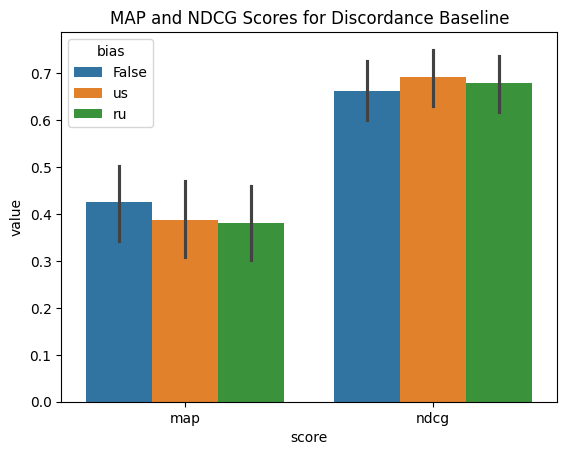

In [59]:
df = basedf[(basedf['min_samples'] ==2) & (basedf['eps'] ==0.9)]
sns.barplot(df, x='score',y='value',hue='bias').set(title='MAP and NDCG Scores for Discordance Baseline')


In [71]:
m = 0
vals = ''
for eps in [0.1, 0.5,0.9]:
    for min_samples in [2,5,8]:
        for country_bias in [False,'us','ru']:
            df = basedf[(basedf['eps']==eps) & (basedf['min_samples']==min_samples) & (basedf['bias']==country_bias)]
            if df[df['score']=='map']['value'].mean()+ df[df['score']=='ndcg']['value'].mean() > m:
                m = df[df['score']=='map']['value'].mean()+ df[df['score']=='ndcg']['value'].mean()
                vals = '{0} {1} {2}'.format(eps,min_samples,country_bias)
            print('for',eps,min_samples,country_bias)
            print('map',df[df['score']=='map']['value'].mean(), 'ndcg',df[df['score']=='ndcg']['value'].mean())

for 0.1 2 False
map 0.4224706719800451 ndcg 0.6649133007936445
for 0.1 2 us
map 0.3811035601582527 ndcg 0.6981339104261017
for 0.1 2 ru
map 0.3816696669229397 ndcg 0.6730984433171818
for 0.1 5 False
map 0.39849207720836854 ndcg 0.6625787030673069
for 0.1 5 us
map 0.38824530660803025 ndcg 0.6642480486006987
for 0.1 5 ru
map 0.40129215830797554 ndcg 0.6465216808819203
for 0.1 8 False
map 0.3995837686596004 ndcg 0.6474757949841023
for 0.1 8 us
map 0.3891281147841624 ndcg 0.6528591021985372
for 0.1 8 ru
map 0.39849371644845505 ndcg 0.6361479372297157
for 0.5 2 False
map 0.4246811370012244 ndcg 0.663251035497773
for 0.5 2 us
map 0.38518715097931966 ndcg 0.6934390830310779
for 0.5 2 ru
map 0.38500440884132925 ndcg 0.6736486156607417
for 0.5 5 False
map 0.4009923637668608 ndcg 0.6647682597329533
for 0.5 5 us
map 0.3910854923206226 ndcg 0.6615077044386485
for 0.5 5 ru
map 0.4036788459504076 ndcg 0.6472463934306446
for 0.5 8 False
map 0.397446063663175 ndcg 0.6535915147525958
for 0.5 8 us
map 0

In [79]:
vals
df = basedf[(basedf['min_samples'] ==2) & (basedf['eps'] ==0.9) & (basedf['bias'] ==False) ]
df['system'] = 'current'
combined_df = pd.concat([df[['query','score','value','system']],baseline_df])
combined_df


/var/folders/8k/gl791hln58jfjf42l9wnlv140000gn/T/ipykernel_19296/1885828977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['system'] = 'current'


,query,score,value,system
36,news,map,0.480688,current
37,news,ndcg,0.480584,current
90,Happy birthday,map,0.551833,current
91,Happy birthday,ndcg,0.856360,current
144,Cheburashka,map,0.076923,current
...,...,...,...,...
65,Production calendar 2023,ndcg,0.436078,baseline
66,Network city,map,-0.000000,baseline
67,Network city,ndcg,0.700000,baseline
68,Sberbank Online,map,0.538462,baseline


In [93]:
vals
df = statdf[(statdf['min_samples'] ==2) & (statdf['eps'] ==0.9) & (statdf['bias'] ==False) ]
df['system'] = 'current'
stat_baseline_df['system'] = 'baseline'
cstat_df = pd.concat([df[['query','value','system']],stat_baseline_df])
cstat_df[cstat_df['system']=='curent']

,query,value,system


In [98]:
statdf[(statdf['bias'] =='None') ] # (statdf['min_samples'] ==2) & (statdf['eps'] ==0.9) & 

,query,value,eps,min_samples,bias


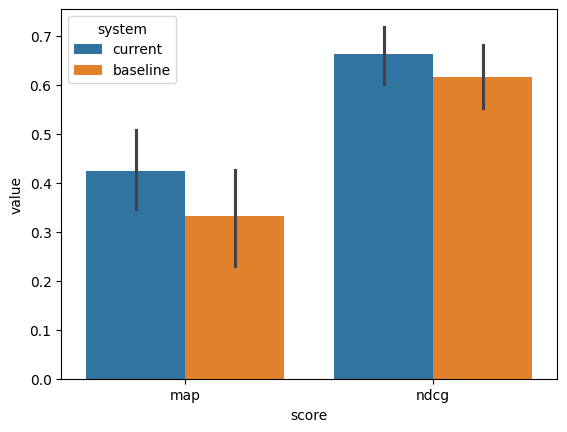

In [81]:
sns.barplot(combined_df, x='score',y='value',hue='system')
plt.savefig('current_baseline_eval.jpg')

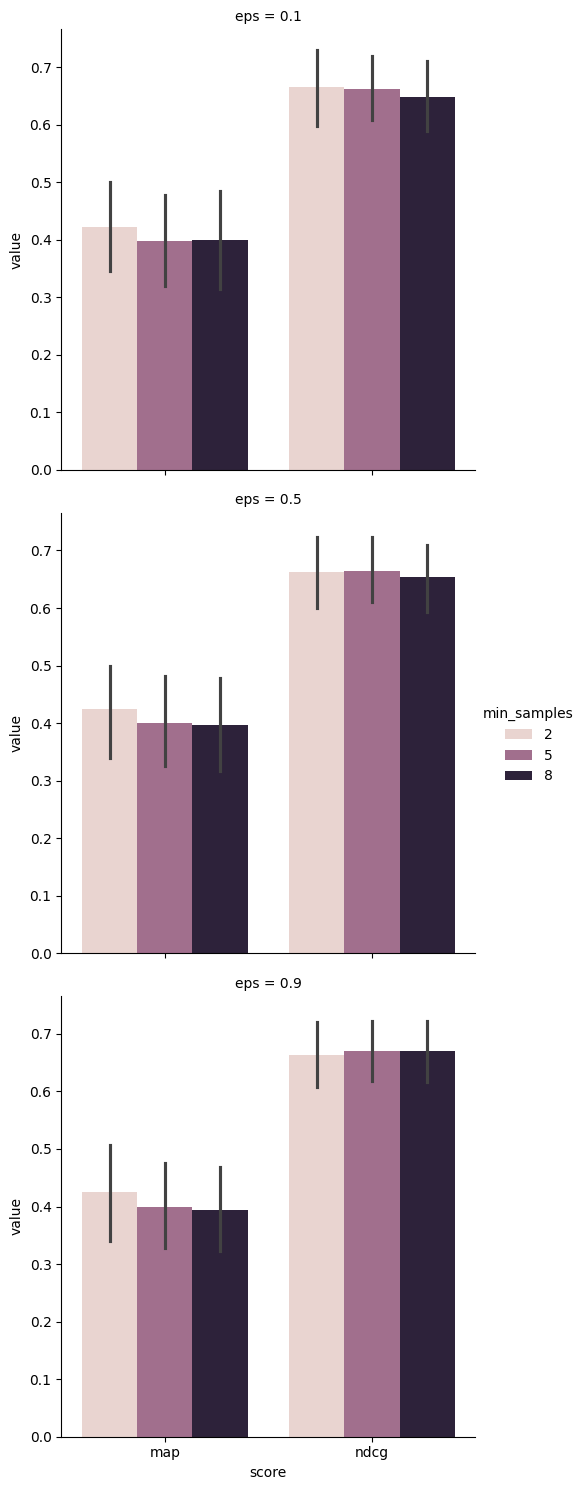

In [82]:
df = basedf[basedf['bias']==False]
sns.catplot(df,x='score',y='value',hue='min_samples',row='eps',kind='bar')
# for i in ax.containers:
#     ax.bar_label(i,)
plt.savefig('hyperparam_scores.jpg')

/var/folders/8k/gl791hln58jfjf42l9wnlv140000gn/T/ipykernel_19296/2639087755.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')


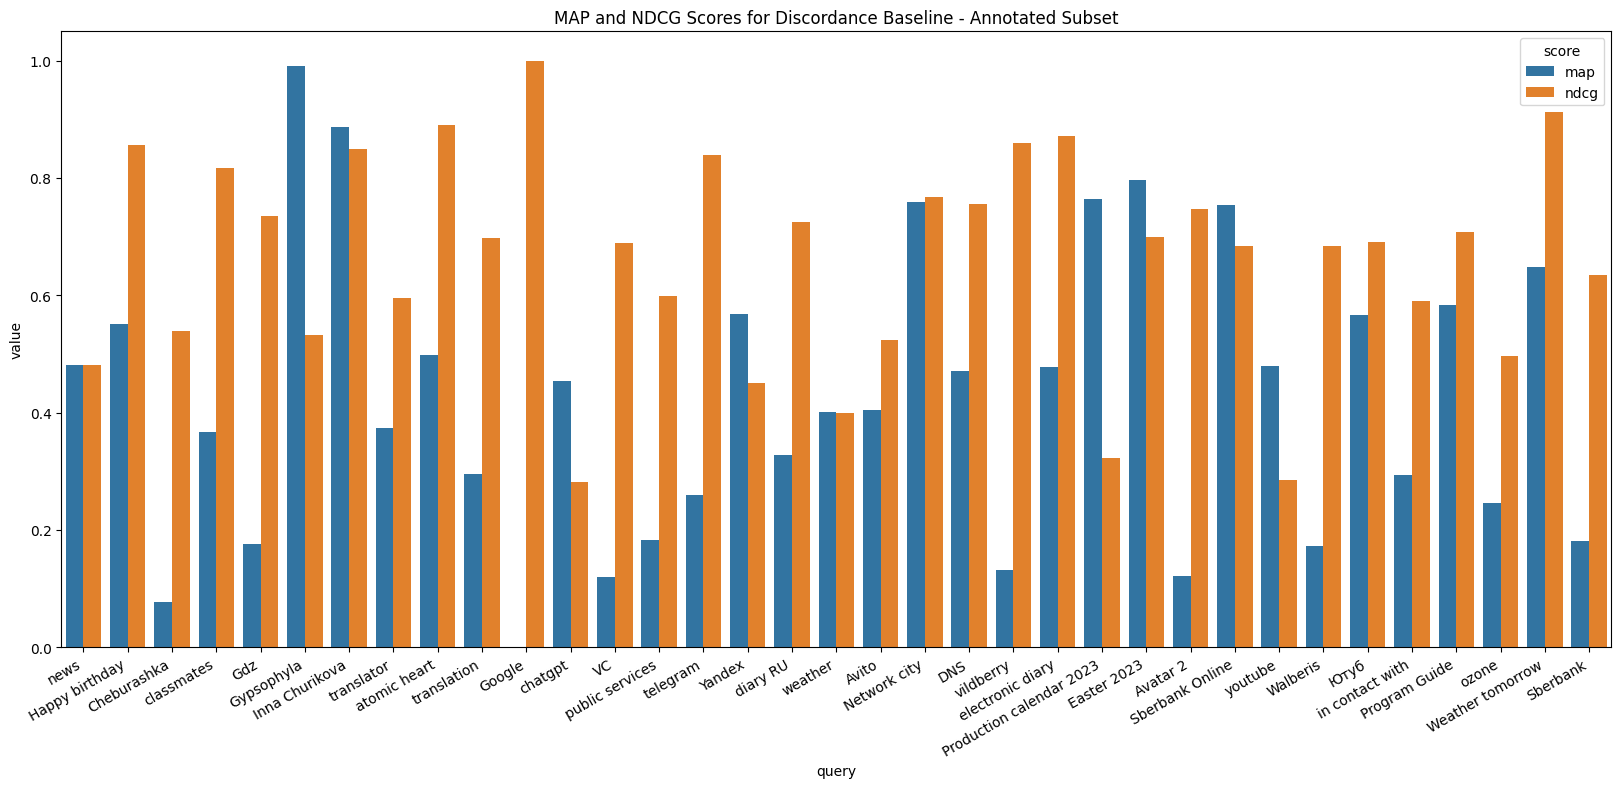

In [84]:
plt.figure(figsize=(20,8))
df = basedf[(basedf['min_samples'] ==2) & (basedf['eps'] ==0.9) & (basedf['bias'] ==False) ]

chart = sns.barplot(df, x='query',hue='score', y='value')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')
chart.set(title='MAP and NDCG Scores for Discordance Baseline - Annotated Subset',)
plt.savefig('full_map_ndcg.jpg')

/var/folders/8k/gl791hln58jfjf42l9wnlv140000gn/T/ipykernel_19296/2446570553.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')


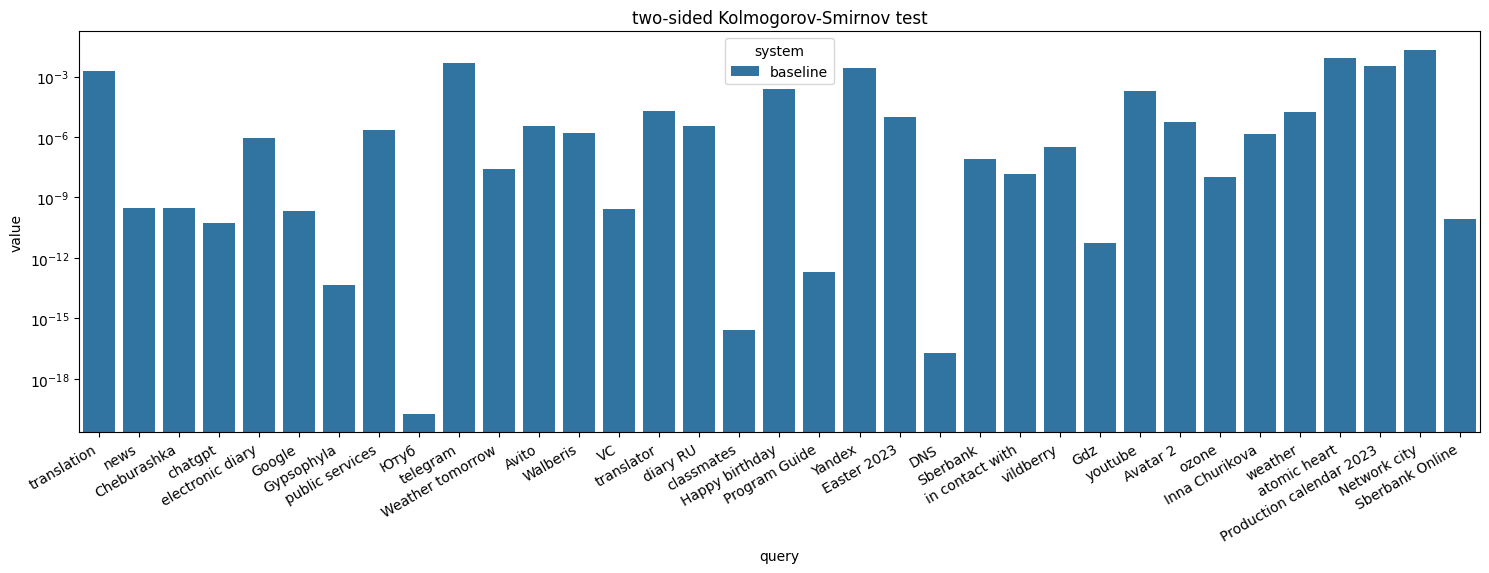

In [89]:
plt.figure(figsize=(15,10))
plt.subplot(211)
chart = sns.barplot(cstat_df, x='query',y='value',hue='system')
chart.set(title='two-sided Kolmogorov-Smirnov test',yscale='log')
chart.set_xticklabels(chart.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.tight_layout()

[Text(0.5, 1.0, 'Annotated Discordance ECDF'), (0.0, 5.0)]

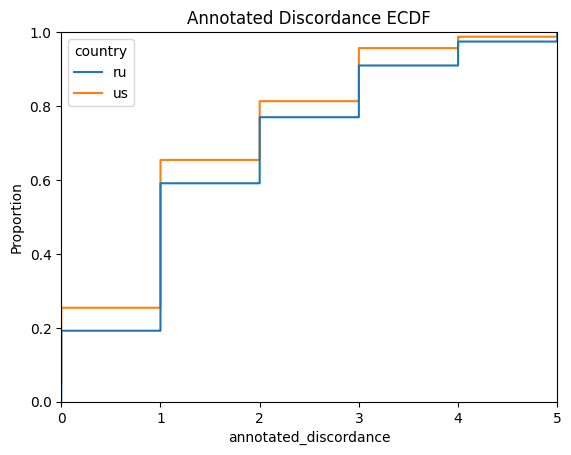

In [66]:
sns.ecdfplot(disc, x='annotated_discordance',hue='country').set(title='Annotated Discordance ECDF', xlim=(0,5))


[Text(0.5, 1.0, 'System Discordance ECDF'), (0.0, 1.1)]

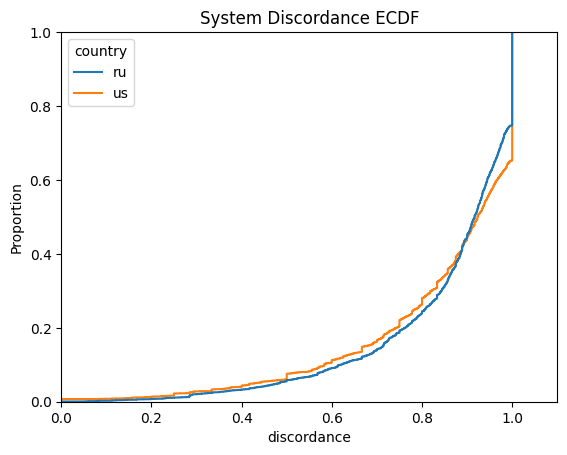

In [63]:
sns.ecdfplot(disc, x='discordance',hue='country').set(title='System Discordance ECDF', xlim=(0,1.1))
